# Project Description

This project predicts the **next day's closing stock price** of Microsoft using historical market data.

The data is based on daily OHLCV values and was processed using time series techniques and an LSTM neural network.

*Made by Alexey V.*



# Task Description

## Purpose

The objective of this project is to build a deep learning model that can **forecast the next day's closing price** of Microsoft stock, using both price-based features and technical indicators.


## Columns in Dataset

**Date** — date of each observation
**Open, High, Low, Close** — standard daily OHLC data
**Volume** — trading volume

Additional features created:

* **Range** = High - Low
* **Close\_Open\_Ratio** = Close / Open
* **SMA\_5**, **SMA\_10**, **SMA\_20** — simple moving averages of Close price



## Tasks

* Load and visualize historical price data
* Engineer features and technical indicators
* Scale and prepare the dataset
* Build an LSTM-based forecasting model
* Train and evaluate the model
* Predict the next day’s closing price



# Table of Contents

### 1. Data loading and visualization

### 2. Feature engineering

### 3. Data scaling and sequence generation

### 4. Model building with LSTM

### 5. Training and validation

### 6. Evaluation and plotting predictions

### 7. Forecasting the next day’s Close price

In [104]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import ta

In [105]:

df = pd.read_csv('Microsoft_stock_data.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

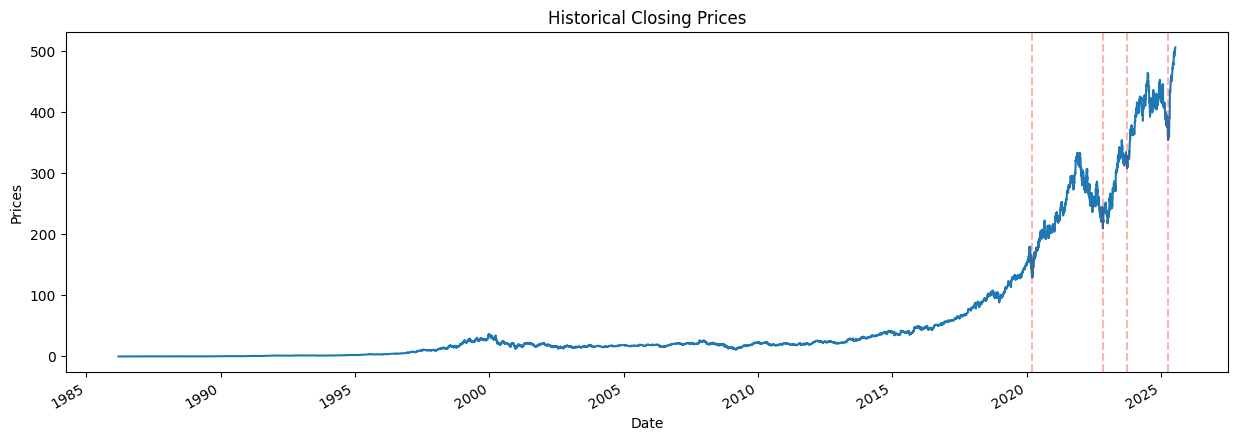

In [106]:
df.index = pd.to_datetime(df.index)
local_min = argrelextrema(df['Close'].values, np.less, order=80)[0]
min_dates = df.iloc[local_min].index
min_datesF = min_dates[(min_dates >= '2020-01-01') & (min_dates <= '2025-12-31')]


plt.figure(figsize=(15, 5))
df['Close'].plot(title='Historical Closing Prices', ylabel='Prices')
for date in min_datesF:
    plt.axvline(date, color='red', linestyle='--', alpha=0.3)
plt.show()

In [107]:

df['Range'] = df['High'] - df['Low']
df['Close_Open_Ratio'] = df['Close'] / df['Open']
for window in [5, 10, 20]:
    df[f'SMA_{window}'] = df['Close'].rolling(window).mean()
df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['Stoch'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close']).stoch()
df.dropna(inplace=True)



scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Close', 'Range', 'Close_Open_Ratio', 'SMA_5', 'SMA_10', 'SMA_20', 'Volume']])

In [108]:
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 1:]) 
        y.append(data[i+seq_length, 0])     
    return np.array(X), np.array(y)

SEQ_LEN = 30
X, y = create_sequences(scaled, SEQ_LEN)

In [109]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(SEQ_LEN, X.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='huber')
model.summary()

e:\Alex\Anaconda\envs\tf_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 30, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.9351e-04 - val_loss: 2.8854e-05
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.4713e-05 - val_loss: 8.0847e-06
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 8.5157e-06 - val_loss: 1.2071e-05
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6.9089e-06 - val_loss: 8.9392e-06
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 5.8812e-06 - val_loss: 1.1086e-05
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 5.3392e-06 - val_loss: 1.4724e-05
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.6337e-06 - val_loss: 5.1509e-06
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.2059e-06 - val_loss: 1.2017e-05
Epoch 9/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.1466e-06 - val_loss: 9.3217e-06
Epoch 10/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.8534e-06 - val_loss: 5.6238e-06
Epoch 11/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/

In [111]:
y_pred = model.predict(X_test)
# Восстановим масштаб Close
def inverse_close(scaled_close, seq_feats):
    return scaler.inverse_transform(
        np.hstack((scaled_close.reshape(-1,1), seq_feats))
    )[:, 0]

last_feats = X_test[:, -1, :]
y_test_inv = inverse_close(y_test, last_feats)
y_pred_inv = inverse_close(y_pred.flatten(), last_feats)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


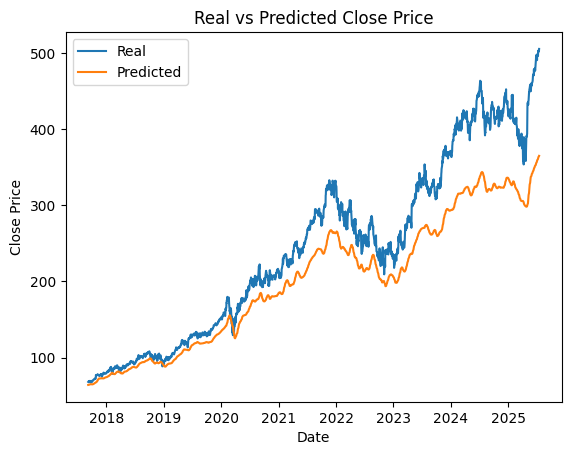

In [112]:
plt.figure()
plt.plot(df.index[-len(y_test):], y_test_inv, label='Real')
plt.plot(df.index[-len(y_pred):], y_pred_inv, label='Predicted')
plt.title('Real vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()



In [113]:

def inverse_close(scaled_close, seq_feats):
    return scaler.inverse_transform(
        np.hstack((scaled_close.reshape(-1, 1), seq_feats.reshape(1, -1)))
    )[:, 0]
last_seq = scaled[-SEQ_LEN:, 1:]
last_seq = last_seq.reshape((1, SEQ_LEN, X.shape[2]))
last_seq_feats = last_seq[0, -1, :]  # (N,)

next_scaled = model.predict(last_seq)
next_price = inverse_close(next_scaled.flatten(), last_seq_feats)

next_price = next_price.flatten()
print(f"Predicted next day Close price: {next_price[0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted next day Close price: 365.9167
